# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #10
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 14th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

During the course of the semester you have worked with a considerable number of sophisticated models. In previous homeworks, you have focused on developing algorithms for performing inference on or prediction using these models. In this assignment, much like in Long Homework #3, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

## Problem #1: A Study of Census Data

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). 

You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 

- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 

Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

In [104]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
import pymc3 as pm

In [105]:
df=pd.read_csv("data 2/census_data.csv", sep=",")


- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school

In [106]:
df.head()

,Unnamed: 0,age,sector,edu,marital,race,sex,earning
0,0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


In [107]:

sample_4cd = df[(df['edu']=='Bachelors')]
sample_Some_college = df[(df['edu']=='Some-college') | (df['edu']=='Assoc-acdm')]
sample_HS = df[(df['edu']=='HS-grad')]
sample_pro_voc = df[(df['edu']=='Prof-school') | (df['edu']=='Assoc-voc')]
sample_mas = df[(df['edu']=='Masters')]
sample_doc = df[(df['edu']=='Doctorate')]
sample_nohigh = df[(df['edu']=='7th-8th') | (df['edu']=='9th') | (df['edu']=='10th') | (df['edu']=='11th') | (df['edu']=='12th') | (df['edu']=='5th-6th') | (df['edu']=='1st-4th') | (df['edu']=='Preschool') ]

In [108]:

def category(name):
    male_tot = name[(name['sex']=='Male') ]
    female_tot = name[(name['sex']=='Female') ]
    male_greater50 = name[(name['sex']=='Male') & (name['earning']=='>50K')]
    female_greater50 = name[(name['sex']=='Female') & (name['earning']=='>50K')]
    return male_tot,male_greater50,female_tot,female_greater50

In [109]:
male_tot_sample_4cd,male_greater50_sample_4cd,female_tot_sample_4cd,female_greater50_sample_4cd = category(sample_4cd)
male_tot_sample_Some_college,male_greater50_sample_Some_college,female_tot_sample_Some_college,female_greater50_sample_Some_college = category(sample_Some_college)
male_tot_sample_HS,male_greater50_sample_HS,female_tot_sample_HS,female_greater50_sample_HS = category(sample_HS)
male_tot_sample_pro_voc,male_greater50_sample_pro_voc,female_tot_sample_pro_voc,female_greater50_sample_pro_voc = category(sample_pro_voc)
male_tot_sample_mas,male_greater50_sample_mas,female_tot_sample_mas,female_greater50_sample_mas = category(sample_mas)
male_tot_sample_doc,male_greater50_sample_doc,female_tot_sample_doc,female_greater50_sample_doc = category(sample_doc)
male_tot_sample_nohigh,male_greater50_sample_nohigh,female_tot_sample_nohigh,female_greater50_sample_nohigh = category(sample_nohigh)



In [110]:

category_name = [sample_4cd,sample_Some_college,sample_HS,sample_pro_voc,sample_mas,sample_doc,sample_nohigh]
name = ['4 year college degree','Some-college or two year academic college degree','High school','Professional, vocational school','Masters','Doctorate','Some or no high school']           


- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school

In [111]:
filtered = pd.DataFrame()

n = 0
m = 1
for i in range(7):   
    filtered.loc[n,'edu'] = name[i]
    filtered.loc[n+1,'edu'] = name[i]    
    filtered.loc[n,'sex'] = 'Male'
    filtered.loc[m,'sex'] = 'Female'

    filtered.loc[n,'>50k'] = category(category_name[i])[1].shape[0]
    filtered.loc[n,'<=50k'] =category(category_name[i])[0].shape[0] -  category(category_name[i])[1].shape[0]
    filtered.loc[n,'total'] =category(category_name[i])[0].shape[0]
    filtered.loc[n,'gender_label'] = 1
    filtered.loc[m,'>50k'] = category(category_name[i])[3].shape[0]
    filtered.loc[m,'<=50k'] =category(category_name[i])[2].shape[0] -  category(category_name[i])[3].shape[0]
    filtered.loc[m,'total'] =category(category_name[i])[2].shape[0]
    filtered.loc[m,'gender_label'] = 0
    
    n += 2
    m += 2
    


In [112]:
filtered

,edu,sex,>50k,<=50k,total,gender_label
0,4 year college degree,Male,1882.0,1854.0,3736.0,1.0
1,4 year college degree,Female,339.0,1280.0,1619.0,0.0
2,Some-college or two year academic college degree,Male,1399.0,3732.0,5131.0,1.0
3,Some-college or two year academic college degree,Female,253.0,2974.0,3227.0,0.0
4,High school,Male,1449.0,5662.0,7111.0,1.0
5,High school,Female,226.0,3164.0,3390.0,0.0
6,"Professional, vocational school",Male,675.0,691.0,1366.0,1.0
7,"Professional, vocational school",Female,109.0,483.0,592.0,0.0
8,Masters,Male,780.0,407.0,1187.0,1.0
9,Masters,Female,179.0,357.0,536.0,0.0


In [113]:
m = filtered['gender_label']
y = filtered['>50k'].astype(int)
n = filtered['total'].astype(int)

In [114]:
def model(m,y):
    with pm.Model() as earning:
        betam = pm.Normal("betam", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + betam * m
        outcome = pm.Binomial("outcome", n=n,p=pm.math.invlogit(logitpi), observed= y)
        
    return earning

def model_nogender(m,y):
    with pm.Model() as earning:      
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha 
        outcome = pm.Binomial("outcome",n=n , p=pm.math.invlogit(logitpi), observed= y)
        
    return earning


<font color = "blue">
### Model:
$${ y }_{ >50k,i } \sim Bernoulli(n_{ i },p_{ i })\\ logit(p_{ i })=\alpha +\beta _{ m }m_{ i }\\ \alpha \sim Normal(0,10)\\ \beta _{ m }\sim Normal(0,10)$$

In [115]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [116]:
results = model(m,y)
with results:
    trace_model1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -3,628.1:  12%|█▏        | 24209/200000 [00:01<00:13, 12724.37it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -2,307.7

100%|██████████| 2000/2000 [00:02<00:00, 902.42it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d9bae48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f8407b8>]], dtype=object)

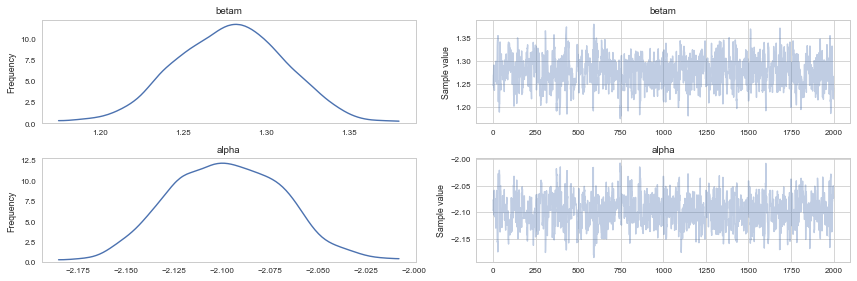

In [117]:
pm.traceplot(trace_model1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  9%|▉         | 18686/200000 [00:01<00:12, 14620.76it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -3,723.5

100%|██████████| 2000/2000 [00:00<00:00, 2076.12it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d25a2b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d72c3c8>]], dtype=object)

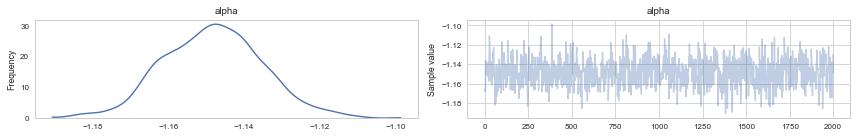

In [118]:
results_nogender = model_nogender(m,y)
with results_nogender:
    trace_model2 = pm.sample(2000)

pm.traceplot(trace_model2)

In [119]:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models)
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort(ic).set_index('Model')
    return comparedf

In [174]:
def compare_plot(comp_df, xlimx, xlimy, ax=None):
    """
    Model comparison summary plot in the style of the one used in the book
    Statistical Rethinking by Richard McElreath.
    Parameters
    ----------
    comp_df: DataFrame
        The result of the pm.compare() function
    ax : axes
        Matplotlib axes. Defaults to None.
    Returns
    -------
    ax : matplotlib axes
    """
    if ax is None:
        _, ax = plt.subplots()

    yticks_pos, step = np.linspace(0, -1, (comp_df.shape[0] * 2) - 1, retstep=True)
    yticks_pos[1::2] = yticks_pos[1::2] + step / 2

    yticks_labels = [''] * len(yticks_pos)
    yticks_labels[0] = comp_df.index[0]
    yticks_labels[1::2] = comp_df.index[1:]

    data = comp_df.values
    min_ic = data[0, 0]

    ax.errorbar(x=data[:, 0], y=yticks_pos[::2], xerr=data[:, 4],
                fmt='ko', mfc='None', mew=1)
    ax.errorbar(x=data[1:, 0], y=yticks_pos[1::2],
                xerr=data[1:, 5], fmt='^', color='grey')

    ax.plot(data[:, 0] - (2 * data[:, 1]), yticks_pos[::2], 'ko')
    ax.axvline(min_ic, ls='--', color='grey')

    ax.set_yticks(yticks_pos)
    ax.set_yticklabels(yticks_labels)
    ax.set_xlabel('Deviance')
    lims=ax.get_ylim()
    ax.set_ylim(lims[0] + step/2., lims[1] - step/2.)
    lims=ax.get_ylim()
    ax.set_ylim(lims[0] + step/2., lims[1] - step/2.)
    ax.set_xlim(xlimx,xlimy)
    return ax

/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


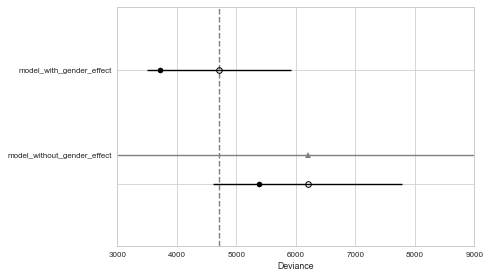

In [177]:
names = ['model_with_gender_effect','model_without_gender_effect']
trace_list = [trace_model1,trace_model2]
model_name = [model(m,y),model_nogender(m,y)]
dfc = make_compare(names, trace_list, model_name, ic='WAIC')
compare_plot(dfc,3000,9000)

In [178]:
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
model_with_gender_effect,4707.77,498.384,0,1,1204.84,0,1
model_without_gender_effect,6200.77,407.044,1492.99,0,1587.41,513764,1


In [124]:
#ppc = pm.sample_ppc(trace_model1, samples=2000, model= model(m,y))
ppc = pm.sample_ppc(trace_model1, samples=2000, model=model(m,y))

100%|██████████| 2000/2000 [00:29<00:00, 67.95it/s]


In [125]:
pp_sample = np.zeros((ppc['outcome'].shape[0],ppc['outcome'].shape[1]))
for i in range(ppc['outcome'].shape[0]):
    pp_sample[i,:] = ppc['outcome'][i,:]/n

In [126]:
original = y/n

<font color = "blue">

### model_gender_without_edu_effect

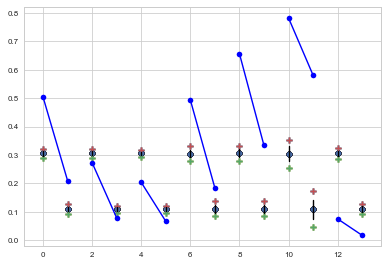

In [127]:

pp_mean = np.mean(pp_sample,axis =0) 
pp_std = np.sqrt(np.var(pp_sample,axis =0))
percentile_0 = np.percentile(pp_sample,2.5,axis = 0)
percentile_1 = np.percentile(pp_sample,97.5,axis = 0)

for i in range(7):
    x1 = np.linspace(2*i,2*i+1, 2, endpoint=True)
    #plt.plot([2*i,2*i+1],[original[2*i],original[2*i+1]])
    plt.plot(x1,[original[2*i],original[2*i+1]],color = 'blue')
    plt.plot(x1,[original[2*i],original[2*i+1]],'o',color = 'blue')
    plt.plot([2*i,2*i],[pp_mean[2*i]-pp_std[2*i],pp_mean[2*i]+pp_std[2*i]],color = 'black')
    plt.plot([2*i+1,2*i+1],[pp_mean[2*i+1]-pp_std[2*i+1],pp_mean[2*i+1]+pp_std[2*i+1]],color = 'black')
    plt.scatter(range(14),pp_mean,edgecolors = 'black')
    plt.scatter(range(14),percentile_0,marker = '+')
    plt.scatter(range(14),percentile_1,marker = '+')
    


<font color = "blue">

### model_without_edu_gender_effect

In [ ]:
ppc1 = pm.sample_ppc(trace_model2, samples=2000, model=model(m,y))
pp_sample1 = np.zeros((ppc1['outcome'].shape[0],ppc1['outcome'].shape[1]))
for i in range(ppc1['outcome'].shape[0]):
    pp_sample1[i,:] = ppc1['outcome'][i,:]/n
    
pp_mean_nogender = np.mean(pp_sample1,axis =0) 
pp_std_nogender = np.sqrt(np.var(pp_sample1,axis =0))
percentile_0_nogender = np.percentile(pp_sample1,2.5,axis = 0)
percentile_1_nogender = np.percentile(pp_sample1,97.5,axis = 0)

for i in range(7):
    x1 = np.linspace(2*i,2*i+1, 2, endpoint=True)
    #plt.plot([2*i,2*i+1],[original[2*i],original[2*i+1]])
    plt.plot(x1,[original[2*i],original[2*i+1]],color = 'blue')
    plt.plot(x1,[original[2*i],original[2*i+1]],'o',color = 'blue')
    plt.plot([2*i,2*i],[pp_mean_nogender[2*i]-pp_std_nogender[2*i],pp_mean_nogender[2*i]+pp_std_nogender[2*i]],color = 'black')
    
    plt.plot([2*i+1,2*i+1],[pp_mean_nogender[2*i+1]-pp_std_nogender[2*i+1],pp_mean_nogender[2*i+1]+pp_std_nogender[2*i+1]],color = 'black')
    plt.scatter(range(14),pp_mean_nogender,edgecolors = 'black')
    plt.scatter(range(14),percentile_0_nogender,marker = '+')
    plt.scatter(range(14),percentile_1_nogender,marker = '+')
    


<font color = "blue">
### Summary for Prob1


As shwn in the WAIC table and plot, based on the value of WAIC, the WAIC for model_with_gender_effect is less than model_without_gender_effect, we may get a general conclusion that gender has an impact on salary. However, since the standard errors are relative large for both models. They are not very ideal in this problem. 

On the other hand, as shown in the posterior check plot, for model_with_gender_effect, the predictive is not matched with our original values precisely. In addition, the result is even worse for model_without_gender_effect and the error is quite large which means that the prediction does not have a good performance.

<font color = "blue">

Model:
$${ y }_{ >50k,i } \sim Bernoulli(n_{ i },p_{ i })\\ logit(p_{ i })=\alpha_i +\beta _{ m }m_{ i }\\ \alpha_i \sim Normal(0,10)\\ \beta _{ m }\sim Normal(0,10)$$

In [189]:
index = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]

In [195]:
def model_edu(m,y):
    with pm.Model() as edu_gender:
        alpha = pm.Normal('alpha',mu=0,sd=10,shape=7)
        betam = pm.Normal('betam',mu=0,sd=10)
        logitpi = alpha[index] + betam * m
        outcome = pm.Binomial('outcome',n = n, p=pm.math.invlogit(logitpi), observed= y)
    return edu_gender

def model_edu_nogender(m,y):
    with pm.Model() as edu_no_gender:
        alpha = pm.Normal('alpha',mu=0,sd=10,shape=7)
        betam = pm.Normal('betam',mu=0,sd=10)
        logitpi = alpha[index]
        outcome = pm.Binomial('outcome',n = n, p=pm.math.invlogit(logitpi), observed= y)
    return edu_no_gender

        
        

In [191]:
results3 = model_edu(m,y)
with results3:
    trace_mode3 = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -98.018: 100%|██████████| 200000/200000 [00:20<00:00, 9952.22it/s] 
Finished [100%]: Average ELBO = -98.024
100%|██████████| 2000/2000 [00:03<00:00, 613.08it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1208bbf60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120efb278>]], dtype=object)

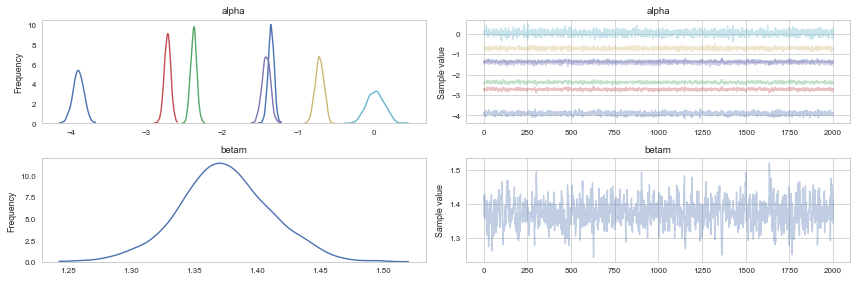

In [192]:
pm.traceplot(trace_mode3)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2,171:  11%|█         | 22136/200000 [00:01<00:15, 11161.09it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -1,216.3

100%|██████████| 2000/2000 [00:04<00:00, 475.76it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121698ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120e036a0>]], dtype=object)

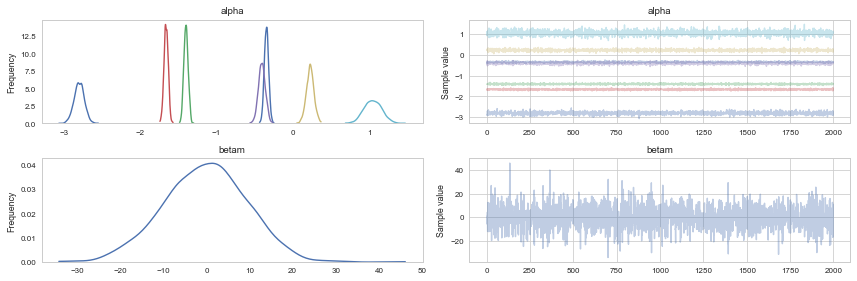

In [196]:
results4 = model_edu_nogender(m,y)
with results4:
    trace_mode4 = pm.sample(2000)
    
pm.traceplot(trace_mode4)

<font color = "blue">

### model_with_gender_edu_effect

100%|██████████| 2000/2000 [00:43<00:00, 45.53it/s]


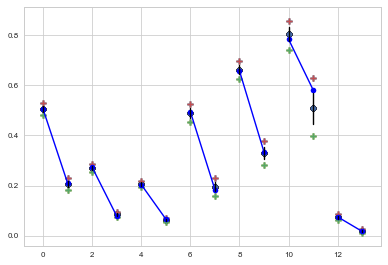

In [197]:

ppc3 = pm.sample_ppc(trace_mode3, samples=2000, model=model_edu(m,y))
pp_sample3 = np.zeros((ppc3['outcome'].shape[0],ppc3['outcome'].shape[1]))
for i in range(ppc3['outcome'].shape[0]):
    pp_sample3[i,:] = ppc3['outcome'][i,:]/n
    

pp_mean3 = np.mean(pp_sample3,axis =0) 
pp_std3= np.sqrt(np.var(pp_sample3,axis =0))
percentile3_0 = np.percentile(pp_sample3,2.5,axis = 0)
percentile3_1 = np.percentile(pp_sample3,97.5,axis = 0)

for i in range(7):
    x1 = np.linspace(2*i,2*i+1, 2, endpoint=True)
    #plt.plot([2*i,2*i+1],[original[2*i],original[2*i+1]])
    plt.plot(x1,[original[2*i],original[2*i+1]],color = 'blue')
    plt.plot(x1,[original[2*i],original[2*i+1]],'o',color = 'blue')
    plt.plot([2*i,2*i],[pp_mean3[2*i]-pp_std3[2*i],pp_mean3[2*i]+pp_std3[2*i]],color = 'black')
    plt.plot([2*i+1,2*i+1],[pp_mean3[2*i+1]-pp_std3[2*i+1],pp_mean3[2*i+1]+pp_std3[2*i+1]],color = 'black')
    plt.scatter(range(14),pp_mean3,edgecolors = 'black')
    plt.scatter(range(14),percentile3_0,marker = '+')
    plt.scatter(range(14),percentile3_1,marker = '+')
    


<font color = "blue">

### model_edu_without_gender_effect

100%|██████████| 2000/2000 [00:32<00:00, 69.42it/s]


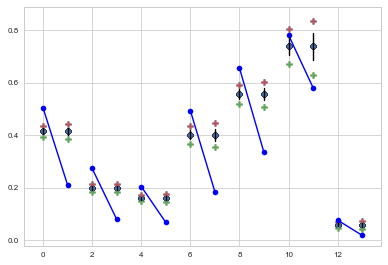

In [198]:

ppc4 = pm.sample_ppc(trace_mode4, samples=2000, model=model_edu_nogender(m,y))
pp_sample4 = np.zeros((ppc4['outcome'].shape[0],ppc4['outcome'].shape[1]))
for i in range(ppc4['outcome'].shape[0]):
    pp_sample4[i,:] = ppc4['outcome'][i,:]/n
    

pp_mean4 = np.mean(pp_sample4,axis =0) 
pp_std4= np.sqrt(np.var(pp_sample4,axis =0))
percentile4_0 = np.percentile(pp_sample4,2.5,axis = 0)
percentile4_1 = np.percentile(pp_sample4,97.5,axis = 0)

for i in range(7):
    x1 = np.linspace(2*i,2*i+1, 2, endpoint=True)
    #plt.plot([2*i,2*i+1],[original[2*i],original[2*i+1]])
    plt.plot(x1,[original[2*i],original[2*i+1]],color = 'blue')
    plt.plot(x1,[original[2*i],original[2*i+1]],'o',color = 'blue')
    plt.plot([2*i,2*i],[pp_mean4[2*i]-pp_std4[2*i],pp_mean4[2*i]+pp_std4[2*i]],color = 'black')
    plt.plot([2*i+1,2*i+1],[pp_mean4[2*i+1]-pp_std4[2*i+1],pp_mean4[2*i+1]+pp_std4[2*i+1]],color = 'black')
    plt.scatter(range(14),pp_mean4,edgecolors = 'black')
    plt.scatter(range(14),percentile4_0,marker = '+')
    plt.scatter(range(14),percentile4_1,marker = '+')
    


/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


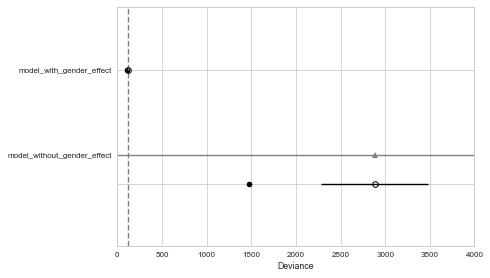

In [206]:
names = ['model_with_gender_effect','model_without_gender_effect']
trace_list = [trace_mode3,trace_mode4]
model_name = [model_edu(m,y),model_edu_nogender(m,y)]
dfc = make_compare(names, trace_list, model_name, ic='WAIC')
compare_plot(dfc,0,4000)

In [207]:
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
model_with_gender_effect,123.264,6.15612,0,1,5.66594,0,1
model_without_gender_effect,2884.7,704.214,2761.44,0,600.011,95213.7,1


/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


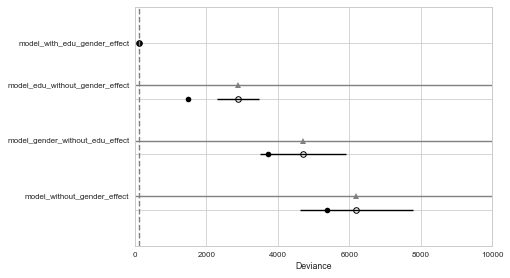

In [212]:
names = ['model_gender_without_edu_effect','model_without_gender_effect','model_with_edu_gender_effect','model_edu_without_gender_effect']
trace_list = [trace_model1,trace_model2,trace_mode3,trace_mode4]
model_name = [model(m,y),model_nogender(m,y),model_edu(m,y),model_edu_nogender(m,y)]
dfc = make_compare(names, trace_list, model_name, ic='WAIC')
compare_plot(dfc,0,10000)

In [213]:
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
model_with_edu_gender_effect,123.264,6.15612,0,1,5.66594,0,1
model_edu_without_gender_effect,2884.7,704.214,2761.44,0,600.011,95213.7,1
model_gender_without_edu_effect,4707.77,498.384,4584.51,0,1204.84,387498,1
model_without_gender_effect,6200.77,407.044,6077.5,0,1587.41,672508,1


<font color = "blue">
### Summary for Prob2
According to the ranking of the four models, model_with_edu_gender_effect is ranked as the best model. It fits our data very well and its prediction error is small. By looking at the weight, model_with_edu_gender_effect is far more resonable than the other 3 models. Therefore, gender and education have an impact on salary. On the other hand, comparing model_edu_without_gender_effect with model_gender_without_edu_effect, the former one has the higher ranking than the latter, which means education probably have a greater effect on salary than gender.

As seen from the posterior check plot, model_with_edu_gender_effect and model_edu_without_gender_effect	are both well matched with our true obseravation, and model_with_edu_gender_effect has the better performance compared with other models. Therefore, we can get a conclusion that gender and education really have an impact on people's salaries.
